# **Tutorial 3 - Supervised Learning**

In this tutorial, we will learn how to use Perceptron and Multi-Layer Perceptron (MLP) neural networks to solve simple classification tasks, and then jump to Convolutional Neural Networks for more complex tasks and explore their analogy with the human visual cortex. We will walk through the necessary steps to implement and train these networks using PyTorch.

**Indicate your responses in the form [here](https://docs.google.com/forms/d/e/1FAIpQLSes-HtR8_99EBUc7fISYgxuObFFUk6YNrMFAEtRDCd6_uTmbg/viewform?usp=publish-editor).**

## Index

1. Single-layer and multi-layer perceptions
  - Generating data
  - Training
  - Evaluation
2. Convolutional neural network
3. Convergence with early visual cortex physiology:
  - Orientation tuning  
  - Spatial frequency tuning  
  - Phase sensitivity vs. invariance
  - Increasing receptive field size across layers

The goal is *intuition*, not biological realism.


###Setup

We first import packages and define helper functions.

In [ ]:
#@title Import and settings (run this code, but feel free to ignore it). {display-mode: "form" }

# Core imports
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import argparse
from pathlib import Path
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Plot settings
plt.rcParams["figure.figsize"] = (5,4)


Now the code below defines some helper functions, e.g. to evaluate a model, plot decision boundaries, generate simple synthetic data and images...

In [ ]:
#@title Helper functions (run this code, but feel free to ignore it). {display-mode: "form" }

# we write here the function that we will use later to evaluate the models on a grid of points
def evaluate_model(model, grid):
    """Function to evaluate a model on a grid of points"""
    with torch.no_grad():
        # get the model's output
        Z = model(grid)
        # apply the sigmoid function to the output
        Z = torch.sigmoid(Z).numpy()
        # binarize the output
        Z = (Z > 0.5).astype(int)
    return Z

def plot_2D_data(X, Y, title, model=None):
    """
    Function to plot the decision boundary and data points of a model
    """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    # add model decision boundary
    if model is not None:
        Z = evaluate_model(model, grid)
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', marker='o')
    plt.title(title)
    plt.show()

def generate_linear_data(N=100, D=2):
    """
    Function to generate linearly separable data
    """
    X = np.random.randn(N, D)
    X[:N//2, :] += 1
    X[N//2:, :] -= 1
    Y = np.concatenate((np.zeros(N//2), np.ones(N//2)))
    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.long)
    return X, Y

def generate_xor_data(N=100):
    """
    Function to generate XOR data
    """
    # Base XOR points
    base_points = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
    base_labels = np.array([0, 1, 1, 0], dtype=np.float32)

    # Generate more points around the base points
    X = []
    Y = []
    for _ in range(N // 4):
        for point, label in zip(base_points, base_labels):
            noise = np.random.normal(0, 0.1, size=point.shape)
            X.append(point + noise)
            Y.append(label)

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y



def get_MNIST_data(batch_size: int = 64):
    """Return train & test DataLoader objects for MNIST."""
    transform = transforms.Compose([
        transforms.ToTensor(),  # → [0,1]
        transforms.Normalize((0.1307,), (0.3081,)),  # standard MNIST mean/std
    ])

    train_ds = datasets.MNIST(
        root="./data",
        train=True,
        download=True,  # downloaded from Yann LeCun's site via torchvision mirror
        transform=transform,
    )
    test_ds = datasets.MNIST(
        root="./data",
        train=False,
        download=True,
        transform=transform,
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, test_loader

# Function to plot images with labels
def plot_mnist_examples(train_loader, num_examples=10):
    # Get a batch of images and labels
    images, labels = next(iter(train_loader))


    plt.figure(figsize=(12, 6))
    for i in range(num_examples):
        plt.subplot((num_examples + 5 - 1) // 5, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def make_grating(size=64, orientation=0, spatial_freq=4, phase=0):
    """Generate a sinusoidal grating stimulus."""
    xs = np.linspace(-1, 1, size)
    ys = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(xs, ys)

    theta = np.deg2rad(orientation)
    Xt = X * np.cos(theta) + Y * np.sin(theta)

    return np.sin(2 * np.pi * spatial_freq * Xt + phase)


def to_tensor(img):
    """Convert a 2D image to a fake RGB tensor for AlexNet."""
    img = torch.tensor(img, dtype=torch.float32)
    img = img.unsqueeze(0).repeat(3, 1, 1)  # RGB
    return img.unsqueeze(0).to(device)

# 1. Single-layer and multi-layer perceptrons
We will first compare standard network architectures on toy examples of classification problems. These two toy example datasets are each made up of 100 data points in two dimensions (i.e. two inputs):
- a **linearly separable dataset** (i.e. the two classes can be perfectly separated by a line - an hyperplane in higher dimension)
- a **non-linearly separable dataset** built following the exclusive-or (XOR) rule <br>
We will test how neural networks of various complexities perform on **learning to classify** each of these datasets.

/tmp/ipython-input-2063061234.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
/tmp/ipython-input-2063061234.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, 0.01))


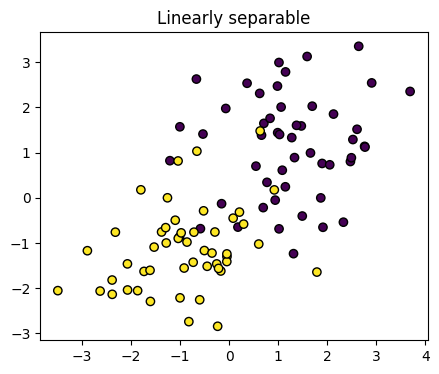

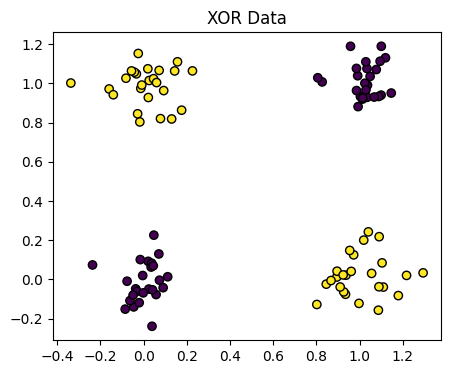

In [ ]:
# Generate and plot the data
# Linearly separable data
X_linear, Y_linear = generate_linear_data()
input_size = 2
output_size = 1
plot_2D_data(X_linear, Y_linear, 'Linearly separable');

# Non-linearly separable data (XOR)
X_xor, Y_xor = generate_xor_data()
plot_2D_data(X_xor, Y_xor, 'XOR Data');

## 1.1 Single-layer perceptron

As you have seen in the lecture, the Perceptron is the simplest artificial neural network. It consists of **a single layer of neurons**, each with a set of weights and biases. The output of the Perceptron is calculated as the weighted sum of the inputs plus the bias, passed through an activation function.

$$z = \mathbf{w} \cdot \mathbf{x} + b = w_1 x_1 + w_2 x_2 + \ldots + w_n x_n + b$$

$$y = \gamma(z)$$

Where:

- $\mathbf{w}$ is the weight vector
- $\mathbf{x}$ is the input vector
- $b$ is the bias
- $\gamma$ is the sigmoid function.
- $\mathbf{z}$ is called the logit.

To implement the perceptron in PyTorch, we can create a class that inherits from `torch.nn.Module` and then define the different elements of the network in the constructor and the forward pass in the `forward` method. We use the matrix multiplication operation `torch.matmul` to calculate the weighted sum of the inputs and the bias.

[Note: although the equations above use the sigmoid function as the activation function, we will not apply it within the model. Instead, we will apply it later when calculating the loss]

In [ ]:
class Perceptron(nn.Module):
    def __init__(self, input_size, output_size):
        super(Perceptron, self).__init__()
        # initialize the weights and bias of the perceptron at random values
        self.W = nn.Parameter(torch.randn(output_size, input_size) * 0.01)
        self.b = nn.Parameter(torch.zeros(output_size))

    def forward(self, x):
        # implement the forward pass of the perceptron
        x = torch.matmul(x, self.W.T) + self.b
        return x

### 1.2 Multi-layer perceptron

The multi-layer perceptron (MLP) is a type of feedforward neural network that consists of multiple layers of neurons. Each layer is fully connected to the next layer. The formula to calculate the output of an MLP is similar to the perceptron, but with the addition of non-linear activation functions $\phi$ between the layers. Here we a two-layer MLP (so one hidden layer and one output layer):

$$z^{(1)} = \mathbf{W}^{(1)} \cdot \mathbf{x} + \mathbf{b}^{(1)}$$
$$h^{(1)} = \phi(z^{(1)})$$
$$z^{(2)} = \mathbf{W}^{(2)} \cdot \mathbf{h}^{(1)} + \mathbf{b}^{(2)}$$
$$y = \gamma(z^{(2)})$$

Where:
- x is the input vector.
- $\mathbf{W}^{(1)}$ and $\mathbf{W}^{(2)}$ are the weight matrices of the first and second layers.
- $\mathbf{b}^{(1)}$ and $\mathbf{b}^{(2)}$ are the bias vectors of the first and second layers.
- $\phi$ is the activation function. In this case, we will use the ReLU activation function (identity if $z>0$, null otherwise).
- $\gamma$ is the output activation function. In this case, we will use the sigmoid activation function.
- $\mathbf{z}$ is called the logit.


Note that if we don't include any non-linear activation functions, the MLP is equivalent to a linear regression model. However, by adding non-linear activation functions, the MLP can learn complex patterns in the data.

[Note: although the equations above use the sigmoid function as the activation function, we will not apply it within the model. Instead, we will apply it later when calculating the loss]

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, non_linear_activation='relu'):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.nla = non_linear_activation
        # initialize the weights and bias of the MLP at random
        self.W_ih = nn.Parameter(torch.randn(hidden_size, input_size) * 0.01) # weights from input to hidden layer
        self.b_ih = nn.Parameter(torch.zeros(hidden_size)) # bias for hidden layer
        self.W_ho = nn.Parameter(torch.randn(output_size, hidden_size) * 0.01) # weights from hidden to output layer
        self.b_ho = nn.Parameter(torch.zeros(output_size)) # bias for output layer

    def forward(self, x):
        # forward pass at the network: we compute the output for a given input

        # multiply input with connectivity matrix
        z = torch.matmul(x, self.W_ih.T) + self.b_ih

        # apply non-linearity to get activity in hidden layer
        if self.nla=='': # if no nonlinearity
            # apply the first linear layer with no activation function
            h = z
        elif self.nla=='relu':
            # apply a ReLU activation function to the hidden layer
            h = torch.relu(z)
        elif self.nla=='sigmoid':
            # apply a sigmoid activation function to the hidden layer
            h = torch.sigmoid(z)

        # project hidden layer to output layer (no non-linearity yet)
        x = torch.matmul(h, self.W_ho.T) + self.b_ho
        return x

## 1.3 Training procedure

We will now implement the training function. We will use the binary cross-entropy loss with logits, which combines the sigmoid activation function and the binary cross-entropy loss. Note that as we use a single output unit with binary values, this problem is **mathematically equivalent to logistic regression!** (we'll fit the weights of each of the inputs on the output variable)
We will use the Stochastic Gradient Descent (SGD) optimizer to update the weights of the model.
**Take a couple of minutes to inspect how fitting is coded**. As you can see, it's just a sequence of simple operations iterated multiple times (hopefully leading the parameters to converge).
If you remember the theory, learning involves computing the gradient of the loss function and back-propagating it across layers to compute the impact of changing each weight in the network on the loss function. Here we are using torch objects (instead of numpy) so the **gradients are computed automatically** (that's called auto-grad or *automatic differentiation*)!

In [ ]:
def train_model(model, X, Y, num_epochs=1000, print_interval=100, lr=0.1):
    """Fit model weights on training data
    model: ANN (torch object)
    X (torch tensor): input data
    Y (torch tensor): output data
    num_epochs: number of iterations
    print (integer): we'll print the value of the objective functions at this interval, to monitor learning
    lr: learning rate (positive scalar)"""

    # define the loss function (binary cross-entropy, BCE)
    criterion = nn.BCEWithLogitsLoss()

    # define the optimizer (stochastic gradient descent), setting the learning rate
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # loop through fitting iterations
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # pass on the input through model (with current value of parameters) to compute output
        outputs = model(X)

        # calculate the loss function (BCE, i.e how much actual output diverges from model output)
        loss = criterion(outputs, Y.float().view(-1, 1))

        # backpropagate the loss
        loss.backward()

        # update the model's parameters using backpropagation
        optimizer.step()
        if (epoch + 1) % print_interval == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

## 1.4 Train and evaluating the models

Let's train the models you have implemented first on the linearly separable  data and evaluate their performance.
Things you can play with:
- The number of neurons in the hidden layer of the MLP (`hidden_size`)
- The learning rate of the optimizer (`lr`)
- The activation function of the hidden layer of the MLP (`non_linear_activation`)
- The number of epochs for training (`num_epochs`)

The plots below represent the **decision boundary for each model after fitting**, i.e. the line that separate points in the input space where the model predicts a higher probability for 1 vs. higher probability for 0.

**Coding exercice: fill the two missing lines in the code**

/tmp/ipython-input-2063061234.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
/tmp/ipython-input-2063061234.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, 0.01))


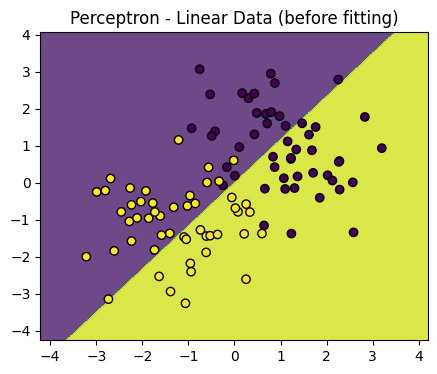

Training the single layer perception on linearly separable data
Epoch [100/1000], Loss: 0.1550
Epoch [200/1000], Loss: 0.1285
Epoch [300/1000], Loss: 0.1178
Epoch [400/1000], Loss: 0.1116
Epoch [500/1000], Loss: 0.1076
Epoch [600/1000], Loss: 0.1046
Epoch [700/1000], Loss: 0.1023
Epoch [800/1000], Loss: 0.1005
Epoch [900/1000], Loss: 0.0990
Epoch [1000/1000], Loss: 0.0978


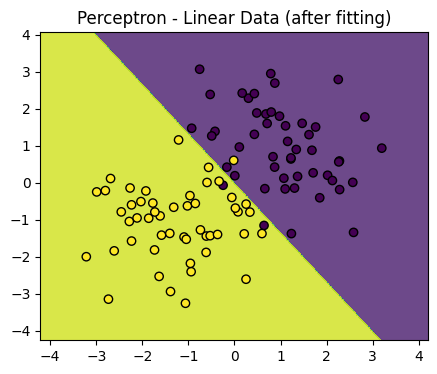

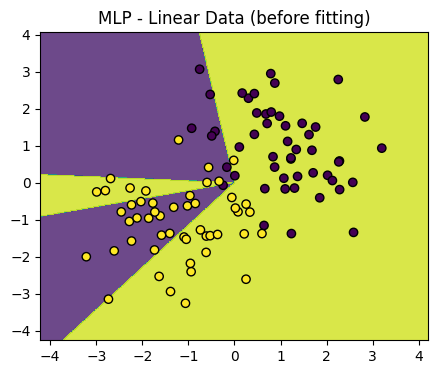

Training the multi-layer perception on linearly separable data
Epoch [100/1000], Loss: 0.3128
Epoch [200/1000], Loss: 0.1123
Epoch [300/1000], Loss: 0.0960
Epoch [400/1000], Loss: 0.0909
Epoch [500/1000], Loss: 0.0887
Epoch [600/1000], Loss: 0.0876
Epoch [700/1000], Loss: 0.0870
Epoch [800/1000], Loss: 0.0866
Epoch [900/1000], Loss: 0.0864
Epoch [1000/1000], Loss: 0.0862


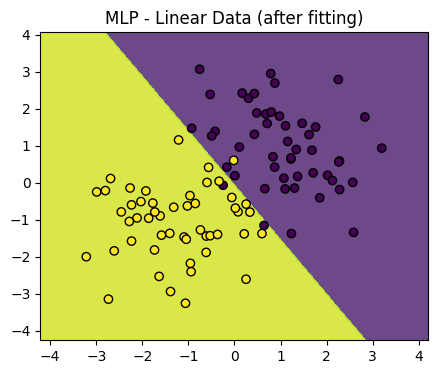

In [ ]:
hidden_size = 10  # number of neurons in the hidden layer (for MLP only)
lr = 0.1  # learning rate
non_linear_activation = 'relu'  # activation function for the hidden layer
num_epochs = 1000  # number of training epochs

# Task 1: generate Linearly Separate Two Clouds of Dots
X_linear, Y_linear = generate_linear_data()

# !! Fill the code here: define the dimensionality of the input and output spaces
input_size = ??
output_size = ??

# Perceptron: define model and plot before fitting
model_perceptron = Perceptron(input_size, output_size)
plot_2D_data(X_linear, Y_linear, 'Perceptron - Linear Data (before fitting)', model=model_perceptron)

# fit model to data and replot decision boundary
print("Training the single layer perception on linearly separable data")
train_model(model_perceptron, X_linear, Y_linear, num_epochs=num_epochs, lr=lr, print_interval=100)
plot_2D_data(X_linear, Y_linear, 'Perceptron - Linear Data (after fitting)', model=model_perceptron)

# same for MLP
model_mlp = MLP(input_size, hidden_size, output_size,
                 non_linear_activation=non_linear_activation)
plot_2D_data(X_linear, Y_linear, 'MLP - Linear Data (before fitting)', model=model_mlp)

print("Training the multi-layer perception on linearly separable data")
train_model(model_mlp, X_linear, Y_linear, num_epochs=num_epochs, lr=lr, print_interval=100)
plot_2D_data(X_linear, Y_linear, 'MLP - Linear Data (after fitting)', model=model_mlp)

**Q1 - What do you observe for decision boundaries?**

*Copy your answer on the Google form.*

**Q2 - What do you observe regarding the loss function for the two ANNs? How does it depend on the learning rate? How do you interpret it?**

*Copy your answer on the Google form.*



**Q3- Is the comparison between the loss function of two models "fair"? What should have we done differently to properly compare the two models?**

*Copy your answer on the Google form.*

Training the single layer perception on XOR data
Epoch [100/1000], Loss: 0.6931
Epoch [200/1000], Loss: 0.6931
Epoch [300/1000], Loss: 0.6930
Epoch [400/1000], Loss: 0.6930
Epoch [500/1000], Loss: 0.6930
Epoch [600/1000], Loss: 0.6930
Epoch [700/1000], Loss: 0.6930
Epoch [800/1000], Loss: 0.6930
Epoch [900/1000], Loss: 0.6930
Epoch [1000/1000], Loss: 0.6930


/tmp/ipython-input-2063061234.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
/tmp/ipython-input-2063061234.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, 0.01))


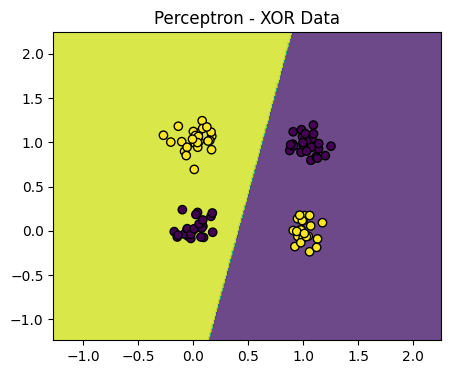

Training the multi-layer perception on XOR data
Epoch [100/1000], Loss: 0.6931
Epoch [200/1000], Loss: 0.6927
Epoch [300/1000], Loss: 0.6910
Epoch [400/1000], Loss: 0.6832
Epoch [500/1000], Loss: 0.6490
Epoch [600/1000], Loss: 0.5358
Epoch [700/1000], Loss: 0.3489
Epoch [800/1000], Loss: 0.2086
Epoch [900/1000], Loss: 0.1353
Epoch [1000/1000], Loss: 0.0965


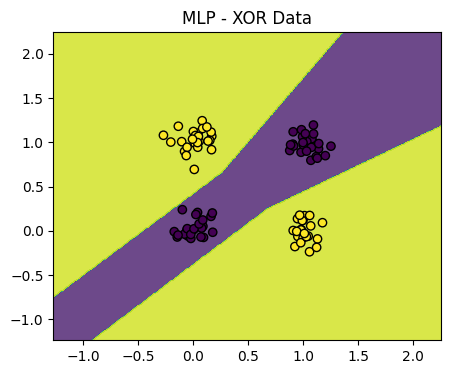

In [ ]:
# Task 2: generate XOR dataset
X_xor, Y_xor = generate_xor_data()

# Perceptron
model_perceptron = Perceptron(input_size, output_size)
print("Training the single layer perception on XOR data")
train_model(model_perceptron, X_xor, Y_xor, num_epochs=num_epochs, lr=lr, print_interval=100)
plot_2D_data(X_xor, Y_xor, 'Perceptron - XOR Data', model=model_perceptron)

# MLP
model_mlp = MLP(input_size, hidden_size, output_size,
                 non_linear_activation=non_linear_activation)
print("Training the multi-layer perception on XOR data")
train_model(model_mlp, X_xor, Y_xor, num_epochs=num_epochs, lr=lr, print_interval=100)
plot_2D_data(X_xor, Y_xor, 'MLP - XOR Data', model=model_mlp)

**Q4 - What do you observe now for the two models? Comment on the decision boundaries and loss function.**

*Copy your answer on the Google form.*

# 2. Convolutional Neural Network (CNN) and digit classification

We will now move to a more interesting task, which is to classify images using Convolutional Neural Networks (CNNs). CNNs are a type of neural network that is particularly effective for image classification tasks. They use convolutional layers to automatically learn spatial hierarchies of features from images. We will download the MNIST dataset, which contains **images of handwritten digits**, and implement a simple CNN to classify these images.

As you have seen in the lecture, unlike a perceptron, which connects every input to every neuron, a convolutional layer uses a small kernel (or filter) that slides over the input image to detect local features, such as edges or patterns.

For a 2D convolution, the output at a given location is computed by taking the element-wise product between the kernel and a local region of the input, and summing the result:

$$
z_{i,j} = \sum_{m=1}^{k} \sum_{n=1}^{k} w_{m,n} \cdot x_{i+m,j+n} + b
$$

$$
y_{i,j} = \gamma(z_{i,j})
$$

Where:

* $w_{m,n}$ are the weights of the kernel  
* $x_{i+m,j+n}$ is a small patch from the input  
* $b$ is the bias term  
* $\gamma$ is the activation function (typically ReLU)  
* $z_{i,j}$ is the result of the convolution at position $(i,j)$


To implement a convolutional layer in PyTorch, we use the `nn.Conv2d` class. It takes as input the number of input channels (e.g., 1 for grayscale), the number of output channels (i.e., filters), the kernel size, and optionally the stride and padding.

For example:

```python
nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
```

This defines a convolutional layer with 32 filters, each of size 3×3, applied to a single-channel input. Padding ensures the output has the same spatial size as the input.

After applying a convolution, we typically use an activation function like ReLU, followed by a pooling operation (e.g., max pooling) to reduce the spatial dimensions and retain the most important features.


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # First convolutional layer:
        # Input: 1 channel (grayscale image), Output: 32 feature maps
        # Kernel size: 3x3, Padding: 1 (keeps output size same as input)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        # Activation function: ReLU (applied after conv1)
        self.relu1 = nn.ReLU(inplace=True)

        # Max pooling: 2x2 window, reduces spatial size by half (e.g. 28x28 → 14x14)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Second convolutional layer:
        # Input: 32 channels from previous layer, Output: 64 feature maps
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Activation function after conv2
        self.relu2 = nn.ReLU(inplace=True)

        # Second max pooling: reduces 14x14 → 7x7
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Flatten the feature maps before the fully connected layers
        self.flatten = nn.Flatten()

        # Fully connected (dense) layer:
        # Input: 64 channels × 7 × 7 pixels = 3136 units
        # Output: 128 hidden units
        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=128)

        # ReLU activation
        self.relu3 = nn.ReLU(inplace=True)

        # Dropout layer for regularization (25% of units are dropped during training)
        self.dropout = nn.Dropout(p=0.25)

        # Final fully connected layer: 128 → 10 (one for each digit class)
        self.fc2 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):
        # the forward pass is a sequence of operations defined above
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

def train_epoch(model, loader, criterion, optimizer, device):
    """Function to train the model for one epoch
    """
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # sum loss function over all images in dataset
        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(targets).sum().item()
        total += targets.size(0)

    return running_loss / total, correct / total


def evaluate(model, loader, criterion, device, show_examples=False, num_examples=6):
    """Function to evaluate the model on the test set
    """

    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    # To store a few predictions for optional visualization
    example_images, example_preds, example_labels = [], [], []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)

            if show_examples and len(example_images) < num_examples:
                for i in range(min(inputs.size(0), num_examples - len(example_images))):
                    example_images.append(inputs[i].cpu())
                    example_preds.append(preds[i].item())
                    example_labels.append(targets[i].item())

    if show_examples:
        plt.figure(figsize=(12, 4))
        for i in range(len(example_images)):
            plt.subplot(1, num_examples, i + 1)
            plt.imshow(example_images[i].squeeze(), cmap="gray")
            plt.title(f"Pred: {example_preds[i]}\nTrue: {example_labels[i]}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    return running_loss / total, correct / total

Let's import the MNIST dataset.

In [ ]:
# Define batch size
batch_size=64

# get MNIST data (split in training set and test set)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = get_MNIST_data(batch_size=batch_size)

n_train_images = len(train_loader.dataset)
print(f"Total number of images in training set: {n_train_images}")
n_test_images = len(test_loader.dataset)
print(f"Total number of images in test set: {n_test_images}")
print("")

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.94MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.82MB/s]

Total number of images in training set: 60000
Total number of images in test set: 10000




/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Let's plot some images in the training set along with the label (the output we want our network to learn to associate to each image)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


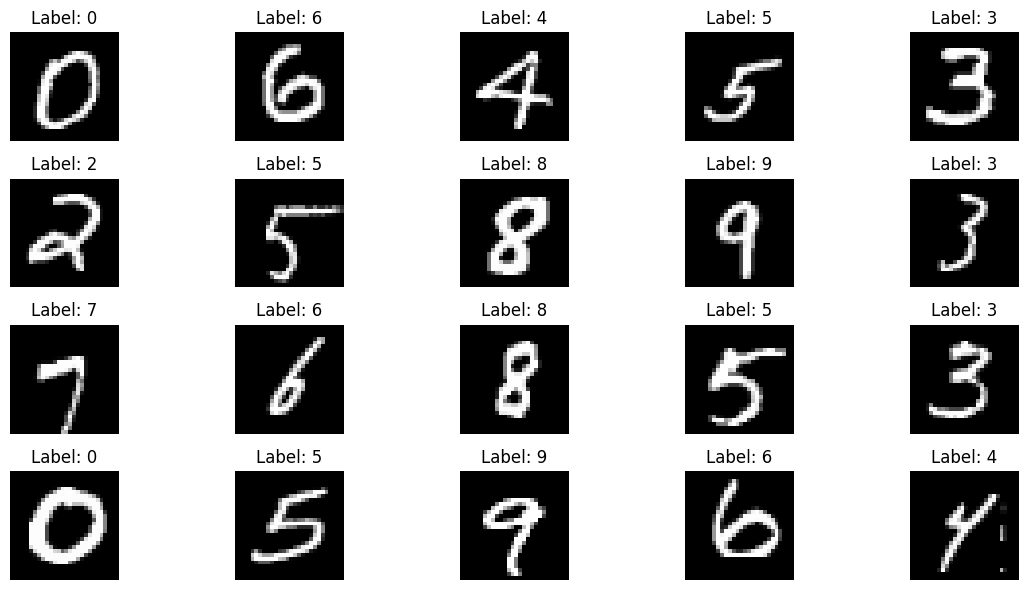

In [ ]:
# Plot some example images with labels
plot_mnist_examples(train_loader, num_examples=20)

Now let's **train our CNN** on the training set and evaluate on the test set (will take a couple of minutes)

Epoch 01/3: train loss 0.163, train acc 94.990% — test loss 0.041, test acc 98.760%
Epoch 02/3: train loss 0.057, train acc 98.245% — test loss 0.035, test acc 98.820%
Epoch 03/3: train loss 0.041, train acc 98.747% — test loss 0.033, test acc 98.780%


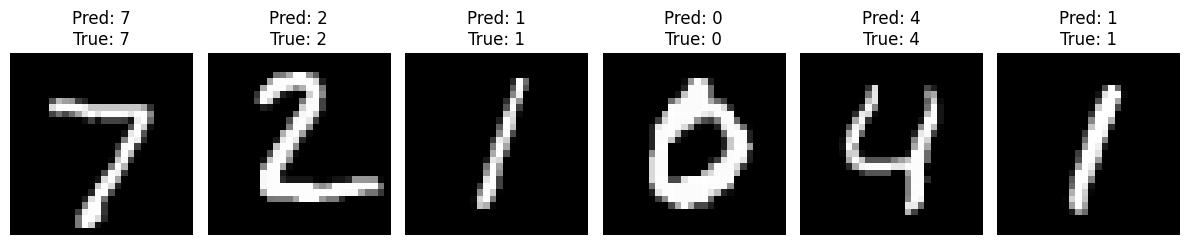

Final test loss: 0.033, test acc: 98.780%


In [ ]:
# Define number of epochs, batch size and learning rate
epochs=3
lr=1e-3

# initialize CNN
model = SimpleCNN().to(device)

# use Cross-Entropy loss and Adam optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train model
for epoch in range(1, epochs + 1):
  train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
  test_loss, test_acc = evaluate(model, test_loader, criterion, device)
  print(
      f"Epoch {epoch:02d}/{epochs}: "
      f"train loss {train_loss:.3f}, train acc {train_acc:.3%} — "
      f"test loss {test_loss:.3f}, test acc {test_acc:.3%}"
  )
# Evaluate the model on the test set with example predictions
test_loss, test_acc = evaluate(model, test_loader, criterion, device, show_examples=True, num_examples=6)
print(f"Final test loss: {test_loss:.3f}, test acc: {test_acc:.3%}")

**Q5- What do you observe?**

*Copy your answer on the Google form.*

# 3. Comparing convolutional nets with electrophysiology of the visual cortex

Here we will use a larger neural network (the classical AlexNet, i.e. the network that triggered the deep learning revolution in 2012) trained on a problem which is much more similar in nature and complexity to that faced by our visual system: object recognition.
We won't train the network on the image dataset to save time and resources but instead download a network that has already been trained on this dataset.
We then look at the properties of the receptive fields on the network units and **compare it to known properties of the human visual cortex**. The goal is *intuition*, not biological realism.

In [ ]:
# Load a pre-trained CNN (AlexNet)
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
model.eval().to(device)

print("Using device:", device)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 163MB/s]


Using device: cpu


We get a description of all the operations in the conv net by just calling its name.

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## a- Receptive fields in first layer
We start by looking at the receptive field in the first layer of the CNN. Remember that, by construction, each unit in layer 1 will only depend on the subset of the image (defined by the kernel) - that defines the *extent of the receptive field*. The size of this kernel will be shared for all units in layer 1, and the kernel itself will be shared by all units in the same channel.

**Q6 - Looking in model description for the *size* of the receptive fields in layer 1 of the conv net.**

*Copy your answer on the Google form.*



Now the precise value of the kernel will vary across channels (although it will be preserved across units in the same channel). So we can plot the kernel for each channel, and this will represent the diversity of receptive fields in layer 1.

**Q7 - How many channels are there in layer 1?**

*Copy your answer on the Google form.*

Let's plot all these kernels!

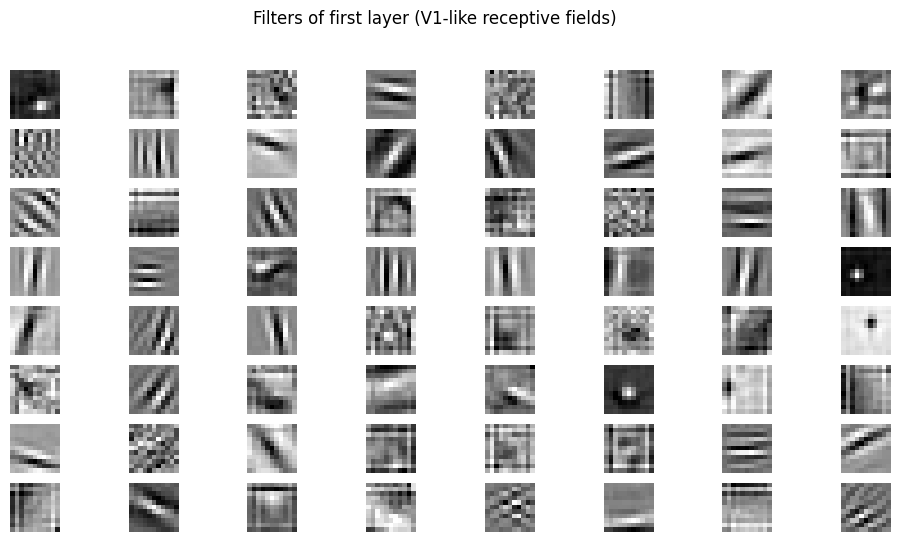

<Figure size 500x400 with 0 Axes>

In [ ]:
# Plot Conv1 filters directly
weights = model.features[0].weight.data.cpu()  # (N, 3, k, k)

# Convert RGB → grayscale for visualization
weights_gray = weights.mean(1)

plt.figure(figsize=(12, 6))
for i in range(64):
    plt.subplot(8, 8, i+1)
    w = weights_gray[i]
    w = (w - w.min()) / (w.max() - w.min())
    plt.imshow(w, cmap="gray")
    plt.axis("off");

plt.suptitle("Filters of first layer (V1-like receptive fields)");
plt.show();
plt.tight_layout();


**Q8 - What do you observe?**

*Copy your answer on the Google form.*

### b. Orientation tuning (V1 simple cells)

Here we will see that the units in the first layer of the conv net have orientation selectivity just like neurons in primary visual cortex (V1).
Here's a grating image where the orientation and spatial frequency are set by two parameters. **Play with these parameters to make sure you understand their role.**

In [ ]:
from ipywidgets import interact, FloatSlider, IntSlider

# Interactive widget
@interact(
    orientation=IntSlider(min=0, max=180, step=1, value=45, description="Orientation (deg):"),
    spatial_freq=IntSlider(min=1, max=10, step=1, value=2, description="Spatial Freq:"),
    phase=FloatSlider(min=0, max=2 * np.pi, step=0.1, value=np.pi, description="Phase:")
)
def update_grating(orientation, spatial_freq, phase):
    g = make_grating(orientation=orientation, spatial_freq=spatial_freq, phase=phase)
    plt.figure()
    plt.imshow(g, cmap='gray')
    plt.axis('off')
    plt.show()


interactive(children=(IntSlider(value=45, description='Orientation (deg):', max=180), IntSlider(value=2, descr…

Let's now feed gratings with all possible orientations to the network and observe how the activity of units depend on this input orientation

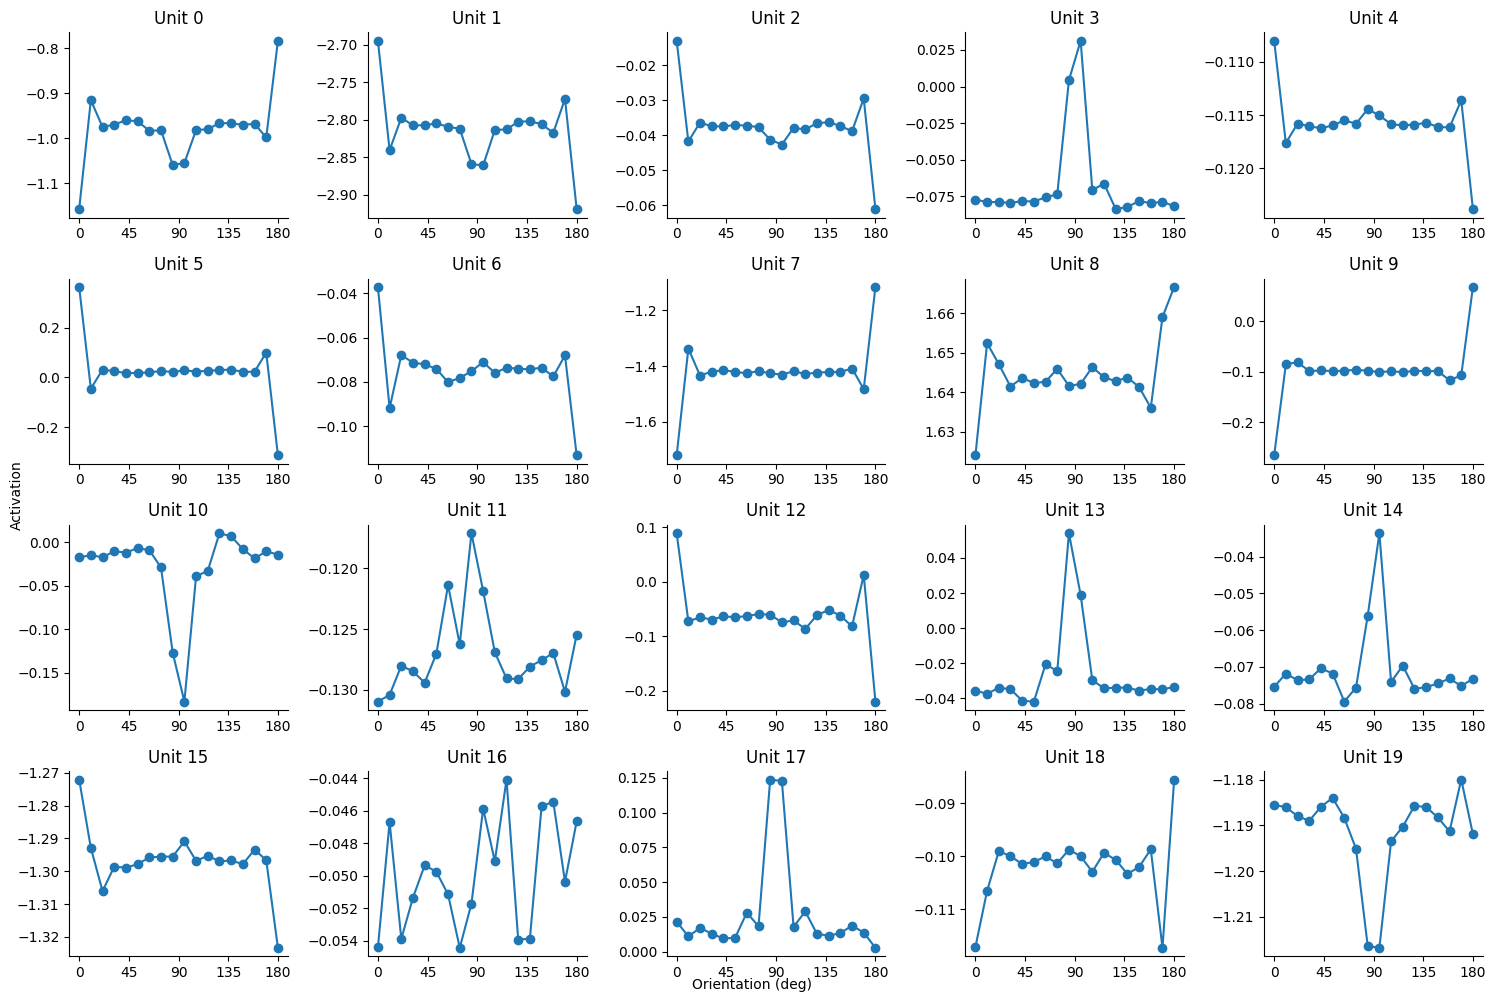

In [ ]:
def orientation_tuning(orientations, model, filter_idx):
  # compute orientation tuning for filter with id filter_idx (in first layer)
  responses = []
  conv1 = model.features[0]   # first convolutional layer

  for ori in orientations:
      g = make_grating(orientation=ori)
      x = to_tensor(g)

      with torch.no_grad():
          act = conv1(x)

      responses.append(act[0, filter_idx].mean().item())

  return responses


orientations = np.linspace(0, 180, 18)

# Create a 4x5 grid of subplots with shared x and y axes
fig, axes = plt.subplots(4, 5, figsize=(15, 10), sharex=False, sharey=False)

# Flatten the axes array for easy iteration
axes = axes.ravel()

# Plot the data in each subplot
for i, ax in enumerate(axes):
    responses= orientation_tuning(orientations, model, i)
    ax.plot(orientations, responses, '-o')
    ax.set_xticks(np.linspace(0,180,5))
    ax.set_title(f"Unit {i}")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single x and y label for the entire figure
fig.text(0.5, 0.01, "Orientation (deg)", ha='center', va='center')
fig.text(0.01, 0.5, "Activation", ha='center', va='center', rotation='vertical')

plt.show();


**Q9 - What do you observe?**

*Copy your answer on the Google form.*

## c- Spatial frequency tuning

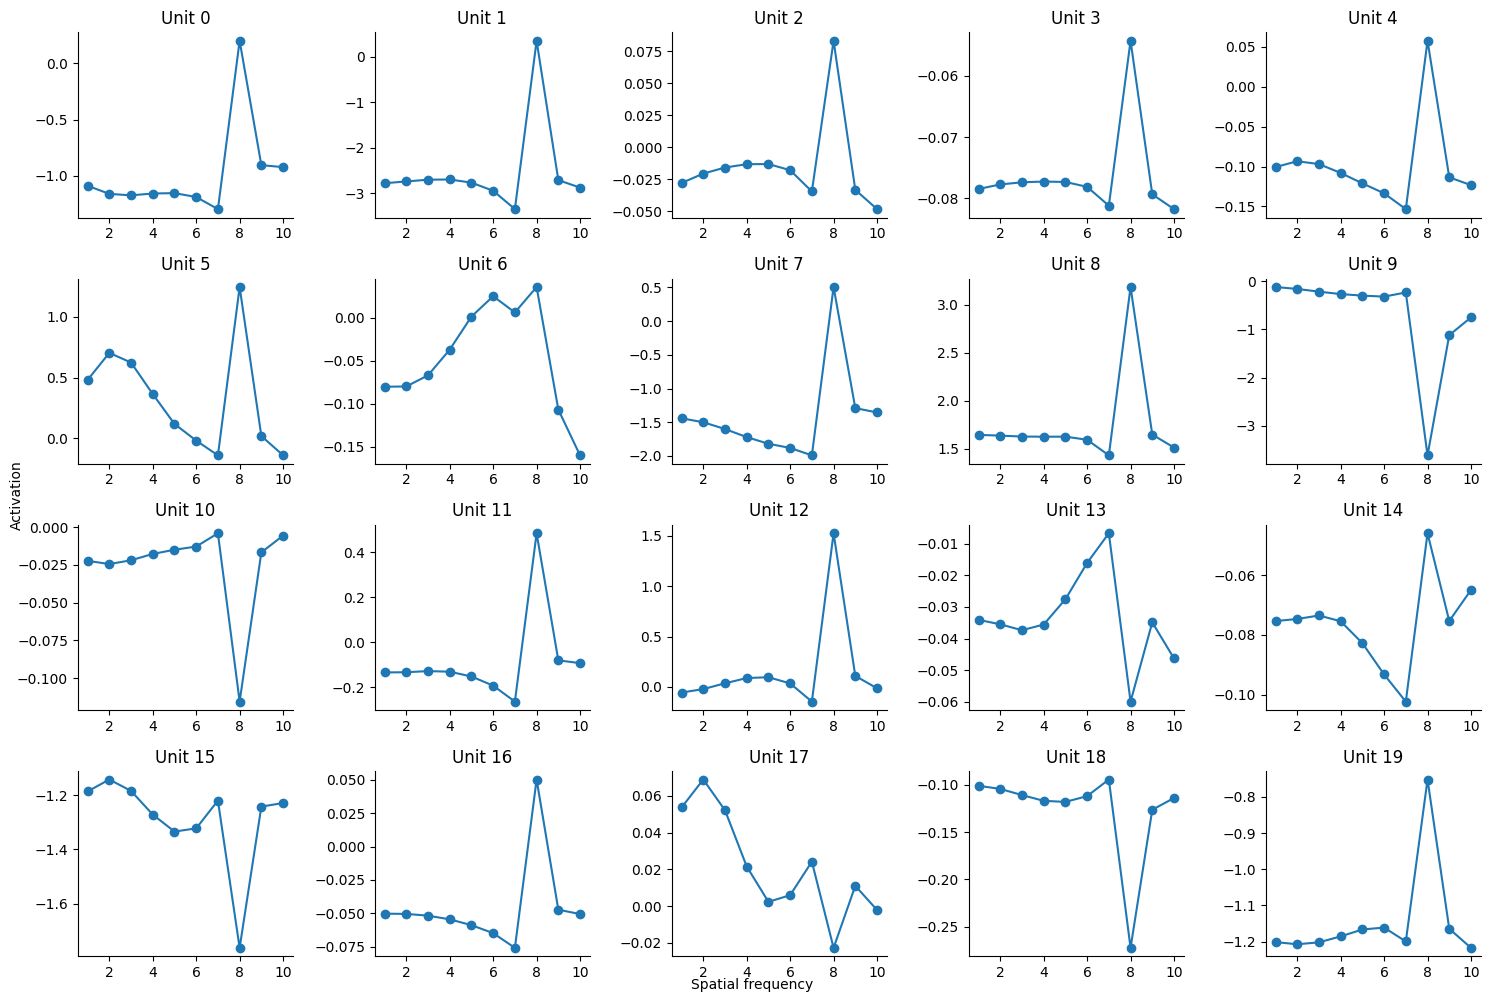

In [ ]:
def frequency_tuning(freqs, model, filter_idx):
  # compute spatial frequency tuning for filter with id filter_idx (in first layer)
  responses = []
  conv1 = model.features[0]   # first convolutional layer

  for f in freqs:
    g = make_grating(spatial_freq=f)
    x = to_tensor(g)

    with torch.no_grad():
        act = conv1(x)

    responses.append(act[0, filter_idx].mean().item())

  return responses

freqs = np.linspace(1, 10, 10)

# Create a 4x5 grid of subplots with shared x and y axes
fig, axes = plt.subplots(4, 5, figsize=(15, 10), sharex=False, sharey=False)

# Flatten the axes array for easy iteration
axes = axes.ravel()

# Plot the data in each subplot
for i, ax in enumerate(axes):
    responses= frequency_tuning(freqs, model, i)
    ax.plot(freqs, responses, '-o')
    ax.set_title(f"Unit {i}")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single x and y label for the entire figure
fig.text(0.5, 0.01, "Spatial frequency", ha='center', va='center')
fig.text(0.01, 0.5, "Activation", ha='center', va='center', rotation='vertical')

plt.show()


**Q10 - What do you observe?**

*Copy your answer on the Google form.*

## d. Receptive field size across CNN layers
Lastly, we will inspect how the size of receptive fields changes across units and layers. In layer 1 we know directly the receptive field because the input directly targets onto it, so this is just the weight matrix of the corresponding channel - and moved horizontally and vertically for each unit within this channel. We cannot use the same metric for deeper layer. Instead we compute an **effective receptive field** which is defined as the gradient of unit activity with respect to input space, e.g. how much the activity of that unit changes if we slightly change one pixel in the original image. This is computed using the following function:

In [ ]:
def effective_receptive_field(model, layer_idx, channel=0, xpos=0, ypos=0):
    """
    Compute effective receptive field of model.features[layer_idx]
    with respect to the input image.
    """
    x = torch.zeros(1, 3, 224, 224, requires_grad=True).to(device)

    # Forward through layers up to layer_idx
    out = x
    for i in range(layer_idx + 1):
        out = model.features[i](out)

    # Take a single unit (mean keeps things stable)
    #y = out[0, 0].mean()
    y = out[0, channel, xpos, ypos]
    y.backward()

    grad = x.grad.abs().mean(1)[0].cpu().numpy()
    return grad


Now let's plot the effective receptive field for one unit in layer 1. Change the channel id, and position of the unit along $(x,y)$ coordinates and observe the effect.

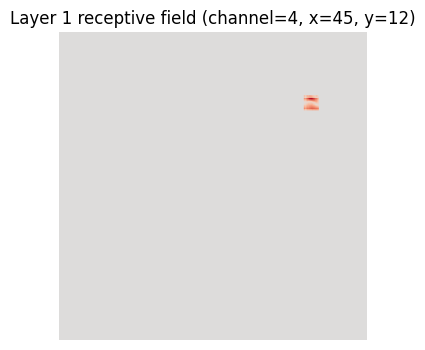

In [ ]:
layer_idx = 0 # corresponds to layer 1 units (before ReLu)
channel = 4 #channel id
xpos = 45 # x- position
ypos = 12 # y - position
grad_conv1 = effective_receptive_field(model, layer_idx=layer_idx, channel=channel, xpos= xpos, ypos=ypos)  # Conv1

plt.figure;
max_abs_value = max(np.abs(grad_conv1.min()), np.abs(grad_conv1.max()))
plt.imshow(grad_conv1.T,  vmin=-max_abs_value,  vmax=max_abs_value,cmap="coolwarm")
plt.title(f"Layer 1 receptive field (channel={channel}, x={xpos}, y={ypos})")
plt.axis("off")
plt.show()

**Q11 - What's the impact of changing the `(x,y)` coordinates of the unit on its effective receptive field?** (without changing channel)

*Copy your answer on the Google form.*

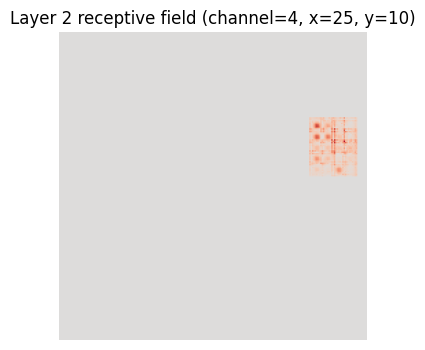

In [ ]:
layer_idx = 3 # Layer 2 (ReLu and MaxPooling are intermediate operations with id 1 & 2)
channel = 4 #channel id
xpos = 25
ypos = 10
grad_conv2 = effective_receptive_field(model, layer_idx=layer_idx, channel=channel, xpos= xpos, ypos=ypos)  # Conv1

plt.figure;
max_abs_value = max(np.abs(grad_conv2.min()), np.abs(grad_conv2.max()))
plt.imshow(grad_conv2.T,  vmin=-max_abs_value,  vmax=max_abs_value,cmap="coolwarm")
plt.title(f"Layer 2 receptive field (channel={channel}, x={xpos}, y={ypos})")
plt.axis("off")
plt.show()

**Q12 - What do you observe regarding the size of units receptive fields? Is this something that the network learns or is it built in the network architecture?**

*Copy your answer on the Google form.*

## Wrap-up

CNNs are *analogies*, not literal cortical models.
They show that many canonical properties of early visual cortex emerge naturally from convolution, nonlinearity, pooling, and natural image statistics.
